In [109]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors
import statsmodels.formula.api as sm
import pandas as pd
from sklearn import linear_model
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn.decomposition import PCA
import random
import json
import gzip
from scipy import spatial
%matplotlib inline

# Hybrid User-Item Similarity Recommendation Model

This model takes a User ID as input and outputs an ordered list of books recommended for that User ID. It is a hybrid of two models that collaboratively filter items user-wise and parse networks of similarly bought or viewed books, respectively.

The user-based model inputs a user ID and identifies that user’s position in a similarity matrix comprising 5000 randomly sampled users from the original universe of Amazon kindle reviewers. Matrix entries correspond to the scores users assigned to products, and for a given input user, the model calculates the user-row’s cosine similarity to all other rows in the matrix. Finally, with the given user’s most similar users on hand, the model recommends items liked by those users for final consideration. The user-based model uses a dataset comprising only the 5000 most frequent reviewers, and the 5000 most frequently reviewed items. The related-products model considers all positively reviewed products that, according to Amazon metadata, were either also viewed or also purchased alongside any product positively reviewed by a given input user. This model considers all products in the complete dataset of metadata.

The hybrid model outputs the intersection of the book lists generated by each model and orders them by their average score in the total dataset of Amazon kindle reviews, comprising almost 1,000,000 reviews.

## Metadata Recommendation Module
### Recommendations via products "also viewed" and "also bought"

This module generates recommendations based on Amazon metadata generously provided by Julian McAuley of UCSD. The metadata includes descriptions, price, sales-rank, brand info, and co-purchasing links based on products sold on Amazon. The metadata file for Kindle books contains 434,702 products. This module also uses a second dataset corresponding to a collection of 982,610 reviews of Amazon Kindle products.

Our goal remains to recommend a list of ranked items to purchase given only a user_id. Here, we implemented the recommendation engine according to the following process:
1. Import and clean both the reviews dataset and the metadata dataset.
2. Given a user_id, extract all products that the user reviewed and filter them by products that the user actually likes (here, we consider this to be products for which the user's review rating was greater than or equal to 4/5).
3. Initialize a pandas Series called running_list which will store all products related to all products that the user has positively reviewed. Iterate through the list of positively reviewed products. For each:
    * Generate list of related products by filtering the metadata dataset by the 'related' column.
    * Iterate through lists according to which related products have been also_bought as opposed to bought_after_viewing. For each, extract the products' mean review scores from the reviews dataset and store the results in running_list.
4. Clean up running_list by dropping duplicates and products that have already been reviewed by the user.
5. Sort the list by its mean review scores and return the final list.

In [2]:
def parse(path):
    g = open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

# Get the metadata
df = getDF('meta_Kindle_Store.json')

In [50]:
print "Product metadata:"
df.head()

Product metadata:


,asin,description,price,imUrl,related,categories,title,salesRank,brand
0,1603420304,In less time and for less money than it takes ...,7.69,http://ecx.images-amazon.com/images/I/51IEqPrF...,"{u'also_viewed': [u'B001OLRKLQ', u'B004J35JIC'...","[[Books, Cookbooks, Food & Wine, Quick & Easy]...",NaN,NaN,NaN
1,B0002IQ15S,This universal DC adapter powers/charges porta...,19.99,http://ecx.images-amazon.com/images/I/21QFJM28...,"{u'also_viewed': [u'B00511PS3C', u'B000PI17MM'...","[[Kindle Store, Kindle Accessories, Power Adap...",Mobility IGO AUTOPOWER 3000 SERIES ( PS0221-10 ),{},NaN
2,B000F83SZQ,NaN,0.00,http://ecx.images-amazon.com/images/I/51yLqHe%...,"{u'also_bought': [u'B0080H1C0W', u'B00LK4ZKOG'...","[[Books, Literature & Fiction], [Books, Myster...",NaN,NaN,NaN
3,B000F83TEQ,NaN,NaN,http://ecx.images-amazon.com/images/I/2136NBNV...,"{u'also_bought': [u'B00IS81LFO', u'B000FA5T6A'...","[[Books, Literature & Fiction], [Books, Myster...",NaN,NaN,NaN
4,B000F83STC,NaN,NaN,http://g-ecx.images-amazon.com/images/G/01/x-s...,NaN,"[[Books, Literature & Fiction, Erotica], [Kind...",NaN,NaN,NaN


In [4]:
data_df = pd.read_csv("reviews.txt")

In [52]:
print "User reviews:"
data_df.head()

User reviews:


,reviewerID,asin,reviewerName,helpful,unixReviewTime,reviewText,overall,reviewTime,summary
0,A1F6404F1VG29J,B000F83SZQ,Avidreader,"[0, 0]",1399248000,I enjoy vintage books and movies so I enjoyed ...,5.0,"05 5, 2014",Nice vintage story
1,AN0N05A9LIJEQ,B000F83SZQ,critters,"[2, 2]",1388966400,This book is a reissue of an old one; the auth...,4.0,"01 6, 2014",Different...
2,A795DMNCJILA6,B000F83SZQ,dot,"[2, 2]",1396569600,This was a fairly interesting read. It had ol...,4.0,"04 4, 2014",Oldie
3,A1FV0SX13TWVXQ,B000F83SZQ,"Elaine H. Turley ""Montana Songbird""","[1, 1]",1392768000,I'd never read any of the Amy Brewster mysteri...,5.0,"02 19, 2014",I really liked it.
4,A3SPTOKDG7WBLN,B000F83SZQ,Father Dowling Fan,"[0, 1]",1395187200,"If you like period pieces - clothing, lingo, y...",4.0,"03 19, 2014",Period Mystery


In [81]:
def recommend_products(user_id):
    
    # Extract Products positively reviewed by that user
    
    products_reviewed = data_df[data_df['reviewerID'] == user_id]
    positive_reviews = products_reviewed[products_reviewed['overall'] >= 4]
    positive_products = list(positive_reviews['asin'])
    
    # Initialize list of related products
    
    running_list = pd.Series()
 
    for product in positive_products:
        related_products = df[df['asin'] == product]['related']
        for entry in related_products:
            if pd.isnull(entry):
                continue
            else:
                for key in entry.keys():

                    # Find review data for products also bought / bought after viewing
                    # Filter them by generally positive reviews and store them in running_list

                    product_ids = list(entry[key])
                    buy_after_viewing = data_df[data_df['asin'].isin(product_ids)]
                    buy_after_viewing = buy_after_viewing.groupby('asin')['overall'].mean()
                    buy_after_viewing = buy_after_viewing[buy_after_viewing >= 4.0]
                    running_list = running_list.append(buy_after_viewing)


    # Delete duplicates from running_list and return final_list
    
    running_list = running_list.drop_duplicates()

    for product in positive_products:
        if product in running_list.index:
            running_list = running_list.drop(product)
    
    final_list = running_list.sort_values(ascending = False)
    
    return final_list

In [82]:
 print "For the user A1F6404F1VG29J we recommend:\n",recommend_products('A1F6404F1VG29J')[:10]

For the user A1F6404F1VG29J we recommend:
B00LK30NEY    5.000000
B00IPY385M    4.916667
B00JLJFJ4S    4.909091
B00K1NURL8    4.900000
B00LMSRVAQ    4.888889
B00K1RB5JW    4.875000
B00GNICK4M    4.857143
B008KFO0AI    4.846154
B00L7BV2F8    4.837209
B00KFRDWMQ    4.833333
dtype: float64


#### Let's examine the top recommendations:

B00LK30NEY    5.000000
<img src='https://images-na.ssl-images-amazon.com/images/I/51MuLrcaQ5L.jpg' style='height:200px'>
<br><br>
B00IPY385M    4.916667
<img src='https://images-na.ssl-images-amazon.com/images/I/51-P4fWur0L.jpg' style='height:200px'>
<br><br>
B00JLJFJ4S    4.909091
<img src='https://images-na.ssl-images-amazon.com/images/I/51ItRB3UFGL.jpg' style='height:200px'>

It looks like there is some sense of coherency among the recommendations. We'll continue this qualitative analysis below.

In [7]:
# reviewers = data_df.groupby('reviewerID').size()
# freq_reviewers = list(reviewers[reviewers > 20].index)
# test_reviewers = random.sample(freq_reviewers, 20)

In [8]:
# print test_reviewers

['A3M0IGG6NGMQXP', 'A2WQ44UKFNAIM', 'A3NU36X7IAA826', 'A2M1PNKPRUCQYL', 'A20NSW4ATF742N', 'A195WCJRKN9KDV', 'A3GUHMXFZRA2NO', 'A4Z44UOCH73BR', 'A32ZHWSB4NJINH', 'A3S5JVB05FN2W2', 'A39QWKXYY8HYDG', 'AR6SCQAD2XGTZ', 'A3THAEKDPJ0ZT8', 'AO1R2DO2EEWHS', 'ANZ16BHO3WGU', 'A3KKUJIY0USHO1', 'AAM0UH7JVBN6O', 'ADQEI7DFNRC82', 'A18OJH46CSHJR4', 'A3SR6J48N94G0M']


## Model Evaluation

In order to evaluate this model, we will run through the steps of the recommendation engine with an example, user A1F6404F1VG29J, and investigate critically whether these recommendations make intuitive sense.

In [9]:
products_reviewed = data_df[data_df['reviewerID'] == 'A1F6404F1VG29J']
positive_reviews = products_reviewed[products_reviewed['overall'] >= 4]
positive_reviews

,reviewerID,asin,reviewerName,helpful,unixReviewTime,reviewText,overall,reviewTime,summary
0,A1F6404F1VG29J,B000F83SZQ,Avidreader,"[0, 0]",1399248000,I enjoy vintage books and movies so I enjoyed ...,5.0,"05 5, 2014",Nice vintage story
57149,A1F6404F1VG29J,B004TS8P7O,Avidreader,"[0, 0]",1402099200,This book take place years ago. I like vintag...,4.0,"06 7, 2014",Vintage western
163614,A1F6404F1VG29J,B006WAZRZK,Avidreader,"[0, 0]",1388275200,I enjoyed this book. I downloaded it because ...,5.0,"12 29, 2013",good story
222667,A1F6404F1VG29J,B0080S6OKE,Avidreader,"[0, 0]",1388275200,I liked this book because Saucy is a unique pe...,5.0,"12 29, 2013",Funky character
278339,A1F6404F1VG29J,B008VFI5D0,Avidreader,"[0, 0]",1400889600,This vintage mystery. The characters were wel...,5.0,"05 24, 2014",Really enjoy vintage novels
596437,A1F6404F1VG29J,B00E5JMQP4,Avidreader,"[1, 1]",1403913600,Good story. Enjoyed learning about a group I ...,5.0,"06 28, 2014",Good story. Enjoyed learning about a group I n...
601364,A1F6404F1VG29J,B00E8JE8DE,Avidreader,"[0, 0]",1403913600,Cute story about 2 orphans. Nice characters. ...,5.0,"06 28, 2014",Nice characters. Exciting for young people
863592,A1F6404F1VG29J,B00J16SQFU,Avidreader,"[0, 0]",1398729600,I enjoyed the book. The characters were belie...,5.0,"04 29, 2014",Really enjoyed the book.
957476,A1F6404F1VG29J,B00KWHKH9K,Avidreader,"[2, 2]",1404345600,Interesting characters. Good story line. Lik...,5.0,"07 3, 2014",Good story line


It looks like this user has made 9 positive Amazon reviews. Users generally find this user's reviews helpful. Let's find out a bit more about the products this user has reviewed.

In [58]:
positive_products = list(positive_reviews['asin'])
for i in df[df['asin'].isin(positive_products)]['categories'][:10]:
    print i

[['Books', 'Literature & Fiction'], ['Books', 'Mystery, Thriller & Suspense', 'Thrillers & Suspense', 'Suspense'], ['Kindle Store', 'Kindle eBooks', 'Mystery, Thriller & Suspense', 'Suspense']]
[['Books', 'Mystery, Thriller & Suspense', 'Mystery', 'Hard-Boiled'], ['Kindle Store', 'Kindle eBooks', 'Nonfiction']]
[['Books', 'Literature & Fiction'], ['Books', 'Mystery, Thriller & Suspense', 'Mystery', 'Hard-Boiled'], ['Books', 'Mystery, Thriller & Suspense', 'Thrillers & Suspense', 'Crime'], ['Kindle Store', 'Kindle eBooks', 'Mystery, Thriller & Suspense', 'Crime Fiction'], ['Kindle Store', 'Kindle eBooks', 'Mystery, Thriller & Suspense', 'Mystery', 'Hard-Boiled']]
[['Books', 'Literature & Fiction'], ['Books', 'Mystery, Thriller & Suspense', 'Mystery', 'Cozy'], ['Books', 'Mystery, Thriller & Suspense', 'Mystery', 'Women Sleuths'], ['Books', 'Mystery, Thriller & Suspense', 'Thrillers & Suspense', 'Suspense'], ['Kindle Store', 'Kindle eBooks', 'Mystery, Thriller & Suspense', 'Mystery', 'Wom

<br><br><br>It looks like for the products positively reviewed by Avidreader, they mostly fall into the categories of "Literature & Fiction," "Mystery, Thriller, & Suspense," "Women Sleuths," "Romance," and "Crime Fiction." It seems like this user has particular taste in books, so it will help to know this information when reviewing the products we have recommended.<br><br><br>

In [59]:
final_list = recommend_products('A1F6404F1VG29J')

<br><br><br>Now that we have our final list of recommendations, let us observe whether the books fall into similar categories as the originally reviewed products by Avidreader.<br><br><br>

In [60]:
book_list = final_list.index
top_20 = book_list[:20]
print top_20

Index([u'B00LK30NEY', u'B00IPY385M', u'B00JLJFJ4S', u'B00K1NURL8',
       u'B00LMSRVAQ', u'B00K1RB5JW', u'B00GNICK4M', u'B008KFO0AI',
       u'B00L7BV2F8', u'B00KFRDWMQ', u'B00EI3E0T2', u'B0089PKMHO',
       u'B00HNSIOHS', u'B00K6H2D5W', u'B00H92XFA4', u'B00F1G8L5O',
       u'B008RZQYN2', u'B006I69YPC', u'B00KL13WXK', u'B00KVMWJRY'],
      dtype='object')


In [62]:
for i in df[df['asin'].isin(top_20)]['categories'][:10]:
    print i

[['Books', 'Literature & Fiction', 'Humor'], ['Books', 'Mystery, Thriller & Suspense', 'Mystery'], ['Kindle Store', 'Kindle eBooks', 'Literature & Fiction', 'Humor & Satire', 'General Humor'], ['Kindle Store', 'Kindle eBooks', 'Mystery, Thriller & Suspense', 'Mystery']]
[['Books', 'Literature & Fiction'], ['Books', 'Science Fiction & Fantasy', 'Fantasy', 'Epic'], ['Books', 'Science Fiction & Fantasy', 'Fantasy', 'Sword & Sorcery'], ['Kindle Store', 'Kindle eBooks', 'Science Fiction & Fantasy', 'Fantasy', 'Coming of Age'], ['Kindle Store', 'Kindle eBooks', 'Science Fiction & Fantasy', 'Fantasy', 'Epic'], ['Kindle Store', 'Kindle eBooks', 'Science Fiction & Fantasy', 'Fantasy', 'Sword & Sorcery']]
[['Books', 'Literature & Fiction', 'Genre Fiction', 'Action & Adventure'], ['Books', 'Mystery, Thriller & Suspense', 'Thrillers & Suspense', 'Spies & Politics', 'Espionage'], ['Kindle Store', 'Kindle Short Reads', 'Two hours or more (65-100 pages)', 'Literature & Fiction'], ['Kindle Store', 'Ki

<br><br><br>Fortunately, this recommendation module has produced recommendations full of mystery, thriller, and suspense novels - so we suspect that these will fall within the interest and taste of Avidreader!<br><br><br>

<br><br><br>
# User-Based Recommendation Module


In [77]:
reviews = pd.read_csv('frequent_reviews_5k.txt', names=['reviewerID', 'asin', 'reviewerName','helpful','time','reviewText','overall','date','summary'],skiprows=1)

In [79]:
print "Reviews of 5k most frequent users and 5k most frequently reviewed books:"
reviews.head()

Reviews of 5k most frequent users and 5k most frequently reviewed books:


,reviewerID,asin,reviewerName,helpful,time,reviewText,overall,date,summary
0,A33EX8MZYBV0YI,B000JMLBHU,alone with books,"[0, 0]",1374537600,"this was an Ok book, but slow at times, I actu...",3.0,"07 23, 2013",the Mysterrous Island
1,A9GPEIJ6JS3UE,B000JMLBHU,Amazon Customer,"[0, 0]",1350432000,"This classic is a must read, especial for anyo...",4.0,"10 17, 2012",Jules Verne is arguably one of the great writters
2,A1BKVWXTMOSN47,B000JMLBHU,blueridge boy,"[0, 0]",1368230400,I enjoyed this book but had trouble following ...,3.0,"05 11, 2013",the mysterious island
3,A3JH1L2JTX27EX,B000JMLBHU,"C. A. Isbell ""bassistann57""","[0, 0]",1385164800,"Again, if you've already seen the movie, this ...",4.0,"11 23, 2013",The Mysterious Island (Jules Verne)
4,AU58Q4M7NCYC9,B000JMLBHU,"David G ""science fiction and fantasy fanatic""","[0, 0]",1404000000,"Every child should read 20,000 leagues under t...",4.0,"06 29, 2014",a classic every child should read - sequel to ...


<br><br><br>First, create two dictionaries:<br>
(1) Map product -> list of reviews for that product<br>
(2) Map reviewer -> list of products that user has reviewed<br><br><br>

In [19]:
products_to_reviewers = dict()
reviewers_to_products = dict()

for review in reviews.itertuples():
    reviewerID = review[1]
    product = review[2]
    helpful = review[4]
    rating = review[7]
    
    # reviewers_to_products will map a reviewer's ID to a tuple containing the product ASIN, 
    # how helpful the user's review was, and their rating of the book
    if reviewerID in reviewers_to_products:
        products_list = reviewers_to_products[reviewerID]
        products_list.append((product, helpful, rating))
        reviewers_to_products[reviewerID] = products_list
    else:
        reviewers_to_products[reviewerID] = [(product, helpful, rating)]

    # products_to_reviewers will map an asin to the list of reviewers that have reviewed that book
    if product in products_to_reviewers:
        reviews_list = products_to_reviewers[product]
        reviews_list.append(reviewerID)
        products_to_reviewers[product] = reviews_list
    else:
        products_to_reviewers[product] = [reviewerID]


<br><br><br>Using these two dictionaries, we construct a (user X product) matrix in which each row represents a user's ratings and each column represents a product. Products that a user has not reviewed are marked 0.<br><br><br>

In [80]:
# Create similarity matrix
# Each row is a user
# Each column is a product
# Each entry in the matrix is the score the user gave that product, or 0 if the user didn't review that product

reviewers = reviewers_to_products.keys()
products = products_to_reviewers.keys()

n_reviewers = len(reviewers)
n_products = len(products)

sim_matrix = np.zeros((n_reviewers, n_products))

for i,reviewer in enumerate(reviewers):
    for j,product in enumerate(products):
        if reviewer not in products_to_reviewers[product]:
            sim_matrix[i, j] = 0
        else:
            reviewer_products = reviewers_to_products[reviewer]
            split = zip(*reviewer_products)
            product_index = (split[0]).index(product)
            rating = split[2][product_index]
            sim_matrix[i, j] = rating

<br><br><br>The core of the user-similarity based recommendations are contained in the following two functions.<br>
<i>similar_users:</i> Performs a pairwise comparison of the input user's row in the above matrix to every other row. It then reports the most similar users and their similarity scores.<br>
<i>product_recs:</i> Generates recommendations by joining the books that the most similar users reviewed positively (and that the input user has not reviewed yet).
<br><br><br>

In [84]:
# Returns the IDs and associated similarity scores of the top 10 most similar users (in descending sorted order)
def similar_users(userID, sim_matrix, reviewers):
    
    # Index of the userID in the similarity matrix
    user_index = reviewers.index(userID)
    
    # The vector representing the passed-in user's product reviews
    user_reviews = sim_matrix[user_index,:]
    similarities = np.zeros(sim_matrix.shape[0])
    for i,user2_reviews in enumerate(sim_matrix):
        similarities[i] = 1 - spatial.distance.cosine(user_reviews,user2_reviews)
    
    # Indices of the top 10 similarities
    ind = np.argpartition(similarities, -10)[-10:]
    ind = ind[np.argsort(similarities[ind])[::-1][:len(similarities)]]
    scores = np.array([similarities[i] for i in ind])
    return ind,scores

In [104]:
# Return product recommendations for a user
def product_recs(userID, sim_matrix, reviewers, reviewer_to_products_dict):
    ind_sim_users,sim_score = similar_users(userID, sim_matrix, reviewers)
    
    # products the passed-in user has already reviewed
    already_reviewed = np.array(zip(*reviewer_to_products_dict[userID])[0]).flatten()
    
    # for each of the top 5 most similar users, get the products that the passed-in user hasn't reviewed
    new_products = []  
    for ind in ind_sim_users[1:6]: # the 0th index is the passed-in user, so skip over it
        reviewer_id = reviewers[ind]
        other_products = np.array(zip(*reviewer_to_products_dict[reviewer_id])[0]).flatten()
        my_products = np.array(zip(*reviewer_to_products_dict[userID])[0]).flatten()
        unique = set(other_products) - set(already_reviewed)
        
        both_reviewed = []
        for item in already_reviewed:
            if item in other_products:
                both_reviewed.append(item)
  
        # RMSE proxy score
        SSE = []
        for item in both_reviewed:
            item_ind = other_products.tolist().index(item)
            my_item_ind = my_products.tolist().index(item)
            other_rating = zip(*reviewer_to_products_dict[reviewer_id])[2][item_ind]
            recommendee_rating = zip(*reviewer_to_products_dict[userID])[2][my_item_ind]
            
            SSE.append((float(other_rating)-float(recommendee_rating))**2)
        
#         print "Items with confidence score of",1 - np.sqrt(np.sum(SSE)/float(len(both_reviewed)))/float(len(both_reviewed))
        
        # Only recommend products that were positively rated by the other user
        for item in unique:
            item_ind = other_products.tolist().index(item)
            rating = zip(*reviewer_to_products_dict[reviewer_id])[2][item_ind]
            
            if rating >= 4:
                new_products.append(item)
#                 print "\t" + item
        
    return new_products

<br><br><br>Now to test out a sample user!<br><br><br>

In [97]:
recs = product_recs('A98DLSC8D0ISO',sim_matrix, reviewers, reviewers_to_products)

Items with confidence score of 0.86583592135
	B00505DKNE
	B00DIGN4JC
	B004S2KL7S
	B00AB2DGE4
	B004U34BZS
Items with confidence score of 0.805318530323
	B004WX1BNG
	B00BOTU4JI
	B005NLPW2C
	B004U34BZS
	B00AB2DGE4
	B00DY8HARG
	B005DPIINI
Items with confidence score of 0.833333333333
	B005J5CZHW
	B00AEA7FWC
	B008PZ6QJG
	B007RMHRMS
	B009ZJ11TG
	B00AK1BOCW
Items with confidence score of 0.846906891076
	B00A73LMES
	B006M6XV1Q
	B008NVWDNK
	B009ZJ11TG
	B004SI455Q
	B008GVC6SE
	B008YPOUPE
	B005DPIINI
	B009CE4TG6
	B004U34BZS
	B00408AQ98
	B005NLPW2C
	B008PZ6QJG
	B0046ZRNEG
Items with confidence score of 0.795875854768
	B00B6GT4H2
	B005U8GQT6
	B008XRI3BA
	B00528HXSM
	B007YX9X18
	B00GNFKEXY
	B0088MF82M
	B004U34BZS
	B00AB2DGE4
	B00ABWN11C
	B00C3JDUJ4
	B006V1MRTO


<br><br><br>It is important to note that these recommendations are not ranked as the item-based module is above. For the corresponding subset of the recommendations shown, we compute a "confidence" metric that acts as a proxy evaluation score for the recommendations. The groupings are according to books that were reviewed by the same subset of users within the list of "similar users". For the books that these reviewers had in common with the input user, we compute a proxy RMSE metric that looks at the differences between the ratings for those items that both the user and those similar users both reviewed. We then theoretically extrapolate this "confidence" level to the quality of the recommended books that the user has not seen yet (and for which we therefore cannot compute a concrete evaluation score). <br><br><br>
<br><br><br>

# The Hybrid Model

The hybrid model takes the intersection of the recommendations made by the item-based and user-based recommendation modules above. It then ranks the results according to the recommendations' average rating among the set of all reviewers. 

In [24]:
# Rank the recommendations
def rank_list(product_list):
    scores = []
    for item in product_list:
        reviews = data_df[data_df['asin'] == item]
        scores.append(reviews['overall'].mean())
    new_list = zip(scores, product_list)
    new_list.sort(reverse = True)
    x_sorted = [scores for product_list, scores in new_list]
    return new_list

In [98]:
# Determine the average rating score of the recommended book across the entire dataset
def global_scores(product_list, reviewers_to_products_dict):
    scores = np.zeros(len(product_list))
    for i,item in enumerate(product_list):
        rvs = products_to_reviewers[item]
        sum_scores = 0
        for user in rvs:
            item_ind = (zip(*reviewers_to_products_dict[user])[0]).index(item)
            sum_scores += zip(*reviewers_to_products_dict[user])[2][item_ind]
        scores[i] = sum_scores / float(len(rvs))
    return scores

In [99]:
# Create final recommendations by taking the intersection of the two sets.
# Returns common_recommendations (intersection), item_recs(from the first module), user_recs(from the second module)
def final_recs(user_id):
    recs = product_recs(user_id, sim_matrix, reviewers, reviewers_to_products)
    recs_2 = recommend_products(user_id)
    if len(recs_2) == 0:
        return [], recs, []
    else:
        recs_2 = recs_2.index.astype(str)
    common = []
    size_user = len(recs)
    size_item = len(recs_2)
    for meta in recs_2:
        for collab in recs:
            if meta == collab and meta not in final_list:
                common.append(meta)
  
    return common,recs,recs_2

<br><br><br>Create a random sampling of reviewers and examine the trends in the size of the intersection of the recommendations.(a larger-sampled version of this histogram is shown on the website!).<br><br><br>

In [110]:
test_reviewers = random.sample(reviewers, 50)
size_intersection = np.zeros(len(test_reviewers))
size_userrecs = np.zeros(len(test_reviewers))
size_itemrecs = np.zeros(len(test_reviewers))
scores_intersection = []
for i,user in enumerate(test_reviewers):
    common_recs,user_recs,item_recs = final_recs(user)
    size_intersection[i] = len(common_recs)
    size_userrecs[i] = len(user_recs)
    size_itemrecs[i] = len(item_recs)
    scores_intersection.append(global_scores(common_recs, reviewers_to_products))

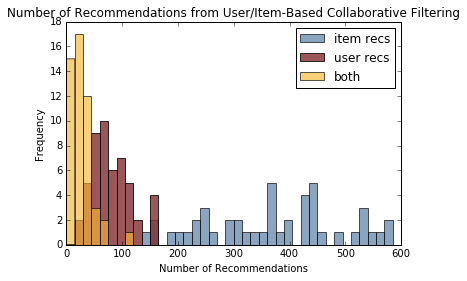

In [111]:
plt.figure()
plt.title("Number of Recommendations from User/Item-Based Collaborative Filtering")
plt.xlabel("Number of Recommendations")
plt.ylabel("Frequency")
bins = range(0,600,15)
plt.hist(size_itemrecs, bins, alpha=0.65, label='item recs', color='#4d749d')
plt.hist(size_userrecs, bins, alpha=0.8, label='user recs', color='#822c31')
plt.hist(size_intersection, bins, alpha=0.65, label='both', color='#f6b733')
plt.legend(loc='best')
plt.show()